# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import json
from PIL import Image
import numpy as np

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define your transforms for the training, validation, and testing sets
data_transforms = {
  'train': transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])]),
  'valid': transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])]),
  'test': transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])
}

In [4]:
# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}

n_categories = len(image_datasets['train'].classes)
print(n_categories)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

102


In [5]:
# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, 
                                              shuffle=True, num_workers=4)
              for x in ['train', 'valid', 'test']}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f) # Category number (as string) to category name

In [7]:
class_names = image_datasets['train'].classes
print(f"Classes: {class_names}")
class_labels = [cat_to_name[c] for c in class_names]
print(f"Classes as text: {class_labels}")

# Folder structure with 'train' as root dir is like: train/1/x.png, train/2/y.png, ..., train/102/xxx.png
# dataset.classes => gives array of ['1', '10', '100', ..., '99'] sorted by string values
#                    in order to get sorted by int values, torchvision>dataset>folder.py module is overwritten as below
#                    just for mind pleasure :)
#
# # ..\anaconda3\envs\py38_env\Lib\site-packages\torchvision\datasets\folder.py
#
# # def find_classes(directory: Union[str, Path]) -> Tuple[List[str], Dict[str, int]]:
# #     """Finds the class folders in a dataset.

# #     See :class:`DatasetFolder` for details.
# #     """
# #     this line added >>> is_alldir_numeric = np.prod([entry.name.isnumeric() for entry in os.scandir(directory) if entry.is_dir()])
# #     this line modified >>> classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()], key=lambda k: int(k) if is_alldir_numeric else k)
# #     ...
# #     return classes, class_to_idx
#      

Classes: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102']
Classes as text: ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'p

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [8]:
# Build and train your network
# Use GPU if it's available
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [9]:
DENSENET161 = 'densenet161'
VGG16BN = 'vgg16_bn'

densenet161_trained_wieghts = models.DenseNet161_Weights.DEFAULT
vgg16bn_trained_weights = models.VGG16_BN_Weights.DEFAULT

densenet161_model = models.densenet161 
vgg16bn_model = models.vgg16_bn

default_model = DENSENET161
model_pref = default_model

In [10]:
# Rubric: A pretrained network such as VGG16 is loaded from torchvision.models and the parameters are frozen
if model_pref == DENSENET161:
    model_train = densenet161_model(densenet161_trained_wieghts)
elif model_pref == VGG16BN:
    model_train = vgg16bn_model(vgg16bn_trained_weights)

# Freeze parameters so we don't backprop through them
for param in model_train.parameters():
    param.requires_grad = False
    
# print(model_train)

c:\Users\kahra\anaconda3\envs\py38_env\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [11]:
default_n_hidden = 4096
inp_n_hidden = default_n_hidden # placeholder n_hidden for future user inputs

if model_pref == DENSENET161:
    n_features = 2208
    model_train.classifier = nn.Sequential(
        nn.Linear(n_features, inp_n_hidden),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2, inplace=False),
        nn.Linear(inp_n_hidden, len(class_names)), # Output layer for 102 flower categories
        nn.LogSoftmax(dim=1))
elif model_pref == VGG16BN:
    n_features = 4096
    features = list(model_train.classifier.children())[:-1] # Remove last layer
    features.extend([nn.Linear(n_features, inp_n_hidden),
                        nn.ReLU(inplace=True),
                        nn.Dropout(p=0.2, inplace=False),
                        nn.Linear(inp_n_hidden, len(class_names)), # Output layer for 102 flower categories
                        nn.LogSoftmax(dim=1)]) # Output layer with 102 outputs
    model_train.classifier = nn.Sequential(*features) # Replace the model classifier
    
print(model_train.classifier)

Sequential(
  (0): Linear(in_features=2208, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=4096, out_features=102, bias=True)
  (4): LogSoftmax(dim=1)
)


In [12]:
default_lr = 0.004
inp_lr = default_lr # placeholder learn rate for future user inputs

default_ne = 3
inp_ne = default_ne # placeholder n_epochs for future user inputs

model_train.to(device)

criterion = nn.NLLLoss()

# Set optimizer and learning rate scheduler
optimizer_ft = optim.SGD(model_train.parameters(), lr=inp_lr, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders['train'])
    val_batches = len(dataloaders['valid'])
    
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch+1, n_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        model.train(True)
        
        for i, data in enumerate(dataloaders['train']):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                
            inputs, labels = data
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            # scheduler.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        avg_loss = loss_train * 1 / len(image_datasets['train'])
        avg_acc = acc_train * 1 / len(image_datasets['train'])
        
        model.train(False)
        model.eval()
            
        for i, data in enumerate(dataloaders['valid']):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            with torch.no_grad():
                inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
                
                optimizer.zero_grad()
                
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                loss_val += loss.item()
                acc_val += torch.sum(preds == labels.data)
                
                del inputs, labels, outputs, preds
                torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / len(image_datasets['valid'])
        avg_acc_val = acc_val / len(image_datasets['valid'])
        
        print()
        print("Epoch {} result: ".format(epoch+1))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        # Check if the avg accuracy at the end of current epoch is higher than 
        # the best accuracy until that epoch, if so, set it as new best accuracy value
        # and make a copy of the state dict of the model 
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [14]:
# Train model
print(f"\nmodel:{model_pref}, n_hidden:{inp_n_hidden}, lr:{inp_lr}, n_epochs: {inp_ne}")
model_trained = train_model(model_train, criterion, optimizer_ft, exp_lr_scheduler, n_epochs=inp_ne)


model:densenet161, n_hidden:4096, lr:0.004, n_epochs: 3
Epoch 1/3
----------
Training batch 800/819
Validation batch 100/103
Epoch 1 result: 
Avg loss (train): 0.3351
Avg acc (train): 0.3948
Avg loss (val): 0.1063
Avg acc (val): 0.7689
----------

Epoch 2/3
----------
Training batch 800/819
Validation batch 100/103
Epoch 2 result: 
Avg loss (train): 0.1413
Avg acc (train): 0.7036
Avg loss (val): 0.0577
Avg acc (val): 0.8790
----------

Epoch 3/3
----------
Training batch 800/819
Validation batch 100/103
Epoch 3 result: 
Avg loss (train): 0.1053
Avg acc (train): 0.7761
Avg loss (val): 0.0457
Avg acc (val): 0.9046
----------


Training completed in 2m 33s
Best acc: 0.9046


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [15]:
# Do validation on the test set
def eval_model(model, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders['test'])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders['test']):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        model.train(False)
        model.eval()
        inputs, labels = data

        with torch.no_grad():
            # if use_gpu:
            #     inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            # else:
            #     inputs, labels = Variable(inputs), Variable(labels)
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

            outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_test += loss.item()
            acc_test += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes['test']
    avg_acc = acc_test / dataset_sizes['test']
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [16]:
eval_model(model_trained, criterion)

Evaluating model
----------
Test batch 100/103
Evaluation completed in 0m 7s
Avg loss (test): 0.0388
Avg acc (test): 0.9219
----------


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [17]:
# Save the checkpoint
def save_checkpoint(save_dir):
  model_trained.cpu()
  checkpoint_path = f'{model_pref}_flowerclassifier.pth'
  checkpoint = {'arch': model_pref,
              'n_hidden': inp_n_hidden,
              'class_to_idx': image_datasets['train'].class_to_idx,
              'optimizer_dict': optimizer_ft.state_dict(),
              'classifier': model_trained.classifier,
              'lr': inp_lr,
              'n_epochs': inp_ne,
              'state_dict': model_trained.state_dict()}
  torch.save(checkpoint, os.path.join(save_dir, checkpoint_path))
  model_trained.to(device)

save_checkpoint(save_dir='pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [18]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(path):
    try:
        checkpoint = torch.load(path)
    except:
        print("Invalid checkpoint path.")
        return None
        
    if checkpoint['arch'] == VGG16BN:
        model = models.vgg16_bn()
    elif checkpoint['arch'] == DENSENET161:
        model = models.densenet161()
    else:
        print("Sorry base architecture note recognized")
        return None
    
    for param in model.parameters():
        param.requires_grad = False
    
    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    
    return model

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [19]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    w, h = image.size
    # Resize
    if w > h:
        w_ = int(w*(256/h))
        image.resize((w_, 256))
    else:
        h_ = int(h*(256/w))
        image.resize((256, h_))
    # Crop 
    left_margin = (image.width-224)/2
    bottom_margin = (image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    image = image.crop((left_margin, bottom_margin, right_margin, 
                    top_margin))
    # Normalize
    image = np.array(image)
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    image = (image/255 - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    image = image.transpose((2, 0, 1))
    return image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [20]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

flowers\test\16\image_06673.jpg


<Axes: >

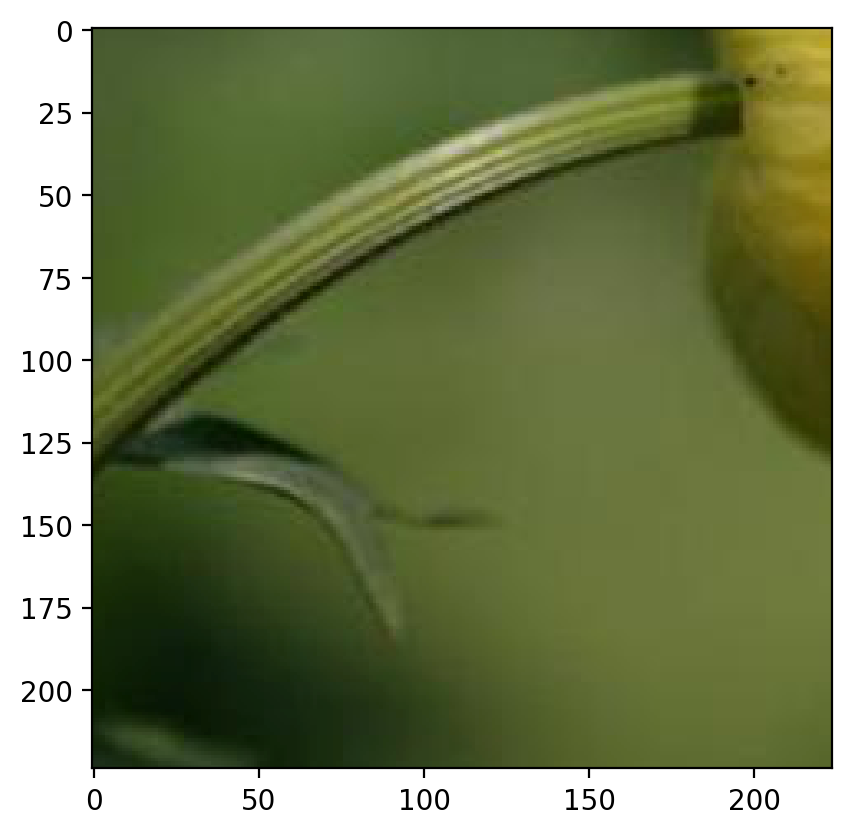

In [21]:
# To test process_image function via randomly generated image paths
def random_img_path(imgset='test'):
  path = os.path.join(data_dir, imgset)
  list_dir_class = os.listdir(path)
  rand_class = list_dir_class[np.random.randint(0, len(list_dir_class))]
  path_rand_class = os.path.join(path, rand_class)
  list_dir_img = os.listdir(path_rand_class)
  rand_img = list_dir_img[np.random.randint(0, len(list_dir_img))]
  path_rand_img = os.path.join(path_rand_class, rand_img)
  return path_rand_img, rand_class

img_path, _ = random_img_path('test')
print(img_path)
img = Image.open(img_path)
imshow(torch.tensor(process_image(img)))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [22]:
default_topk = 5
inp_topk = default_topk # placeholder top-k for future user inputs

In [23]:
# Implement the code to predict the class from an image file
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    
    image = Image.open(image_path)
    image = torch.tensor(process_image(image))
    image.unsqueeze_(0)
    model = model.double()
    
    # Convert class_to_idx keys and values to actual numerical classes
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    
    model.to(device)
    with torch.no_grad():
        output = model(image.to(device))
        top_ps, top_cats = torch.exp(output).data.topk(topk)
    probs = top_ps.tolist()[0]
    categories = list(map(lambda i:idx_to_class[i], top_cats.tolist()[0]))
    cat_names = [cat_to_name[cat] for cat in categories]
    
    return probs, categories, cat_names


In [24]:
# Saved pth files in root directory
pth_files = [file for file in os.listdir(path='./pth') if file.endswith('.pth')]
print(pth_files)

default_check = 1
inp_check = default_check # placeholder checkpoint choice for future user inputs

inp_check_file = os.path.join('pth', pth_files[inp_check-1])
print(inp_check_file)

['densenet161_flowerclassifier.pth']
pth\densenet161_flowerclassifier.pth


In [25]:
# Generate a random image path and make precitions using checkpoint model
def random_predict():
  img_path, img_class = random_img_path('test')
  print(img_path)
  model_loaded = load_checkpoint(inp_check_file)
  probs, classes, cat_names = predict(img_path, model_loaded, inp_topk)
  return img_path, img_class, probs, classes, cat_names

random_predict()

flowers\test\90\image_04430.jpg


C:\Users\kahra\AppData\Local\Temp\ipykernel_17480\1610411555.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


('flowers\\test\\90\\image_04430.jpg',
 '90',
 [0.4069821389337465,
  0.28570852864042057,
  0.06657715785927333,
  0.033810989033438606,
  0.02556494240536384],
 ['90', '11', '46', '53', '94'],
 ['canna lily', 'snapdragon', 'wallflower', 'primula', 'foxglove'])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

flowers\test\78\image_01843.jpg


C:\Users\kahra\AppData\Local\Temp\ipykernel_17480\1610411555.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


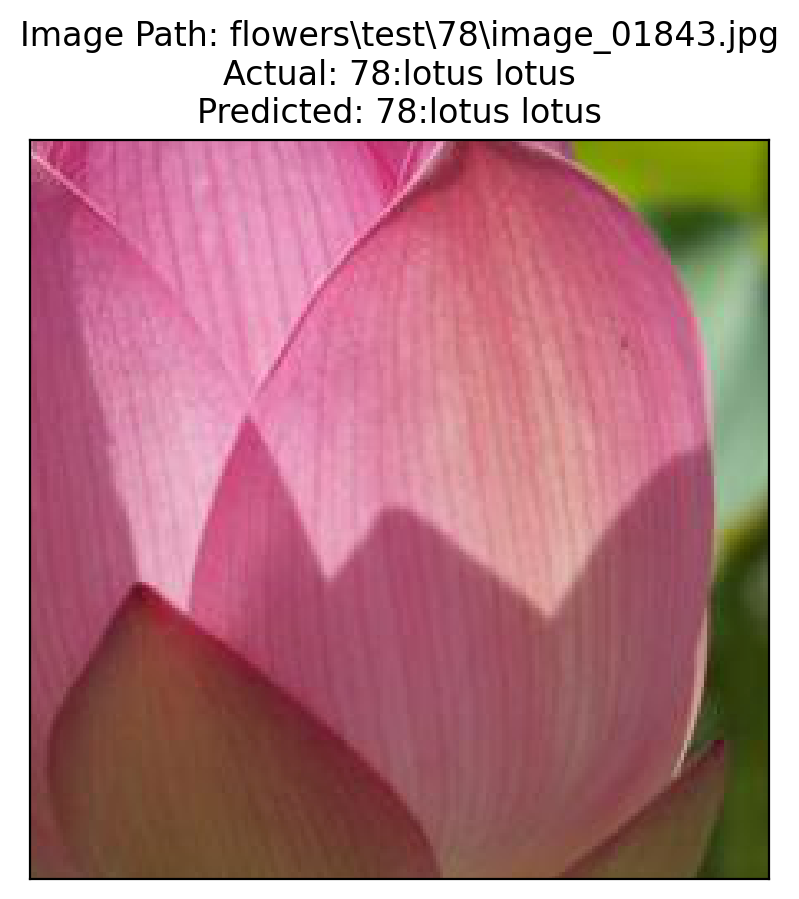

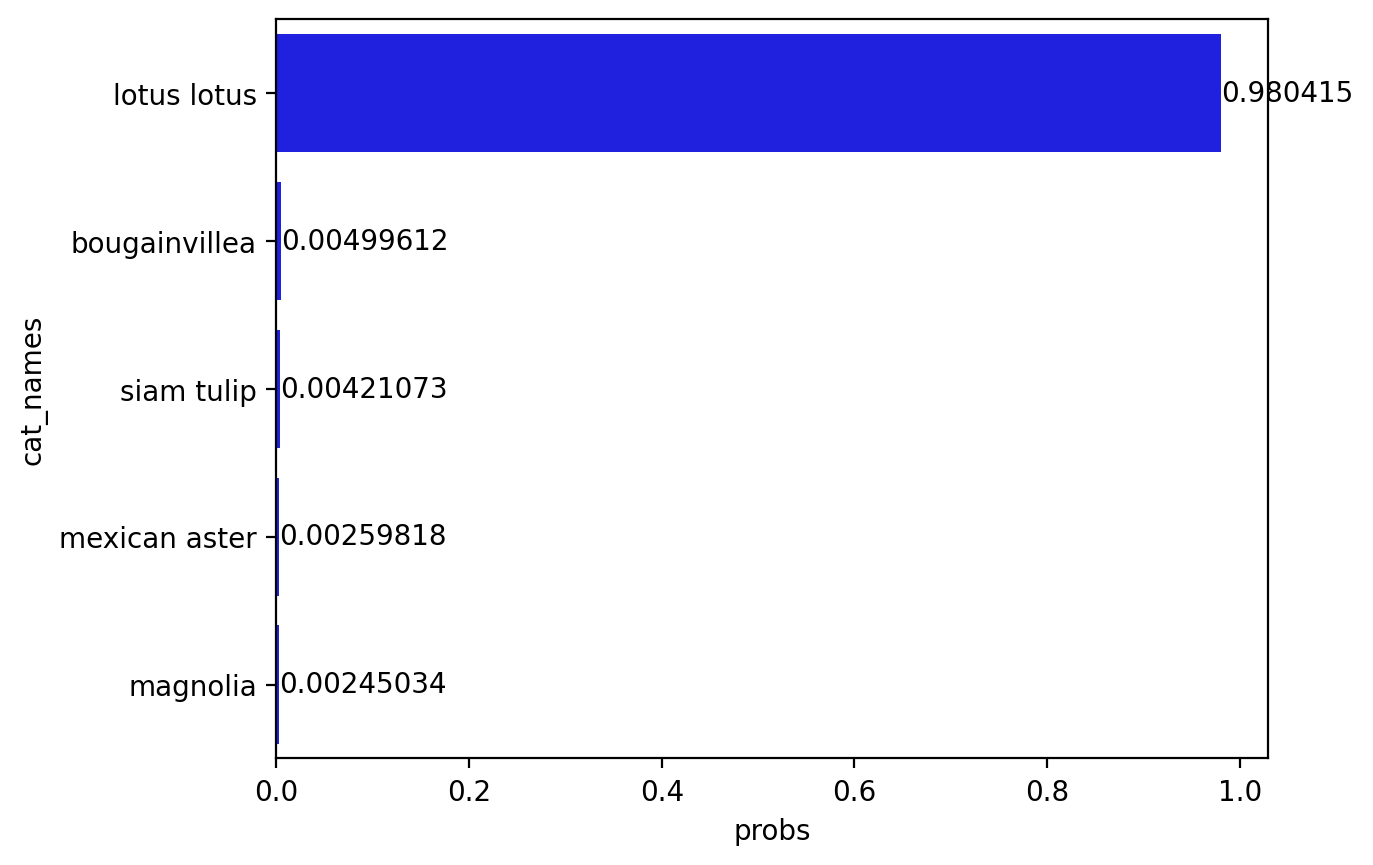

In [26]:
# Display an image along with the top 5 classes
# Choose a random image and then predict its category
img_path, img_class, probs, classes, cat_names = random_predict()
sanity_check = process_image(Image.open(img_path))
# Display the test flower image
ax1 = imshow(torch.tensor(sanity_check))
ax1.set_yticks(list())
ax1.set_xticks(list())
ax1.set_title('Image Path: ' + img_path + '\nActual: ' + img_class + ':' + cat_to_name[img_class] + '\nPredicted: ' + classes[0] + ':' + cat_names[0])

# Create pandas dataframe via probs and category names variable
# then plot using seaborn's barplot
fig, ax_bar = plt.subplots()
data = {'probs' : pd.Series([*probs]), 'cat_names' : pd.Series([*cat_names])}
df = pd.DataFrame(data)
# print(df)
ax2 = sb.barplot(data=df, x='probs', y='cat_names', color='blue')
ax2.bar_label(ax2.containers[0]);

### Notes on Default Values

At the root directory there is folder named 'seek_bestparams'. There are two python modules. For a list of parameters, all combinations are trained sequentially by using inner for loops. Their accuracy and time results along with parameter values are stored in 'results.csv'. Accuracy values vs parameter combinations are plotted in 'results.xlsx' and exported in the same folder to an image namely 'accuaracy_results_mod'. Parameters giving the best accuracy values for each model types is clearly seen there.

By analyzing this work results, defaults options are determined for this project. 
- Default model: densenet161
|__ Default lr: 0.004
|__ Default n_epochs = 3
|__ Default n_hidden = 4096

- Other model: vgg16_bn
|__ Default lr: 0.002
|__ Default n_epochs = 3
|__ Default n_hidden = 4096
